In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("uber.csv")
df.head()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [4]:
df = df.dropna()


In [5]:
df = df[df['fare_amount'] > 0]


In [6]:
df = df[
    (df['pickup_latitude'].between(-90, 90)) &
    (df['dropoff_latitude'].between(-90, 90)) &
    (df['pickup_longitude'].between(-180, 180)) &
    (df['dropoff_longitude'].between(-180, 180))
]


In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


In [8]:
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month


In [9]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371  * c  # Distance in KM

df['distance_km'] = df.apply(
    lambda row: haversine(
        row['pickup_longitude'], row['pickup_latitude'],
        row['dropoff_longitude'], row['dropoff_latitude']
    ),
    axis=1
)


In [10]:
df = df.drop([
    'key',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude'
], axis=1)


In [11]:
df.head()


,Unnamed: 0,fare_amount,passenger_count,hour,day,month,distance_km
0,24238194,7.5,1,19,7,5,1.683323
1,27835199,7.7,1,20,17,7,2.457590
2,44984355,12.9,1,21,24,8,5.036377
3,25894730,5.3,3,8,26,6,1.661683
4,17610152,16.0,5,17,28,8,4.475450


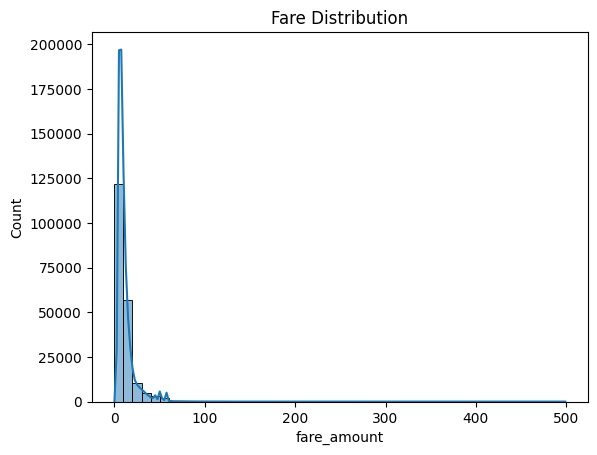

In [12]:
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title("Fare Distribution")
plt.show()


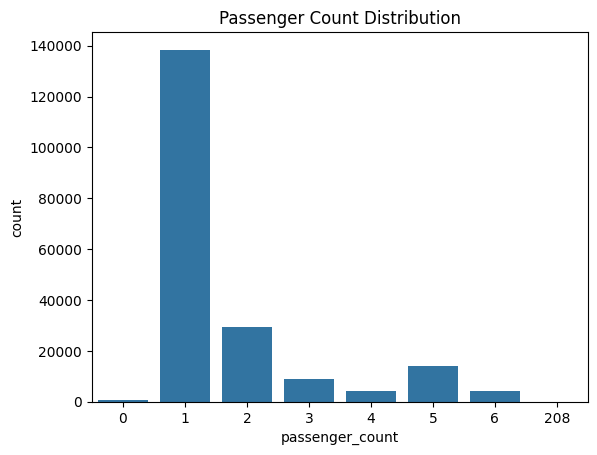

In [13]:
sns.countplot(x='passenger_count', data=df)
plt.title("Passenger Count Distribution")
plt.show()


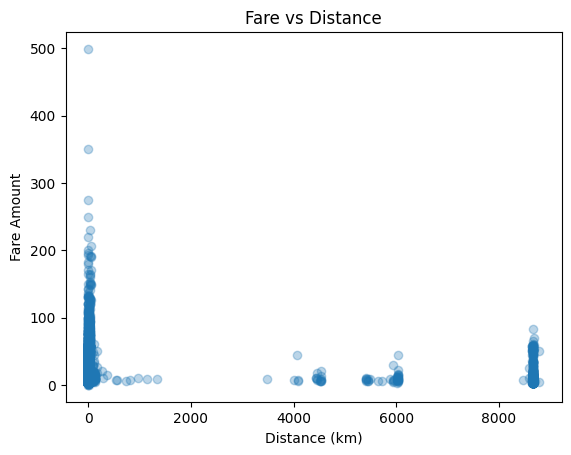

In [14]:
plt.scatter(df['distance_km'], df['fare_amount'], alpha=0.3)
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount")
plt.title("Fare vs Distance")
plt.show()


In [15]:
X = df[['distance_km', 'passenger_count', 'hour', 'day', 'month']]
y = df['fare_amount']


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [17]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_preds = lr_model.predict(X_test)


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Linear Regression MAE:", mean_absolute_error(y_test, lr_preds))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_preds)))


Linear Regression MAE: 5.974307461396025
Linear Regression RMSE: 9.643390727914293


In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=30,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, rf_preds))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))


Random Forest MAE: 2.65766198536704
Random Forest RMSE: 5.326398575453072


In [20]:
import joblib
joblib.dump(rf_model, "uber_fare_model.pkl")


['uber_fare_model.pkl']